<a href="https://colab.research.google.com/github/FiyinfobaO/g05-used-cars/blob/main/new_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# copying dataset from drive to colab current directory
!cp 'drive/My Drive/used_car_dataset.zip' '/content/'

In [ ]:
# unzipping the dataset
%%capture
!unzip '/content/used_car_dataset.zip' 

In [6]:
!pip install catboost

     |████████████████████████████████| 66.3MB 56kB/s 


In [7]:
# import libraries
import gc
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.metrics import r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor, XGBRFRegressor
from catboost import CatBoostRegressor
%matplotlib inline

In [ ]:
# load the dataset 
df = pd.read_csv('/content/vehicles.csv')
df.head()

,Unnamed: 0,id,url,region,region_url,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,image_url,description,state,lat,long,posting_date
0,0,7240372487,https://auburn.craigslist.org/ctd/d/auburn-uni...,auburn,https://auburn.craigslist.org,35990,2010.0,chevrolet,corvette grand sport,good,8 cylinders,gas,32742.0,clean,other,1G1YU3DW1A5106980,rwd,NaN,other,NaN,https://images.craigslist.org/00N0N_ipkbHVZYf4...,Carvana is the safer way to buy a car During t...,al,32.590000,-85.480000,2020-12-02T08:11:30-0600
1,1,7240309422,https://auburn.craigslist.org/cto/d/auburn-201...,auburn,https://auburn.craigslist.org,7500,2014.0,hyundai,sonata,excellent,4 cylinders,gas,93600.0,clean,automatic,5NPEC4AB0EH813529,fwd,NaN,sedan,NaN,https://images.craigslist.org/00s0s_gBHYmJ5o7y...,I'll move to another city and try to sell my c...,al,32.547500,-85.468200,2020-12-02T02:11:50-0600
2,2,7240224296,https://auburn.craigslist.org/cto/d/auburn-200...,auburn,https://auburn.craigslist.org,4900,2006.0,bmw,x3 3.0i,good,6 cylinders,gas,87046.0,clean,automatic,NaN,NaN,NaN,SUV,blue,https://images.craigslist.org/00B0B_5zgEGWPOrt...,Clean 2006 BMW X3 3.0I. Beautiful and rare Bl...,al,32.616807,-85.464149,2020-12-01T19:50:41-0600
3,3,7240103965,https://auburn.craigslist.org/cto/d/lanett-tru...,auburn,https://auburn.craigslist.org,2000,1974.0,chevrolet,c-10,good,4 cylinders,gas,190000.0,clean,automatic,NaN,rwd,full-size,pickup,blue,https://images.craigslist.org/00M0M_6o7KcDpArw...,1974 chev. truck (LONG BED) NEW starter front ...,al,32.861600,-85.216100,2020-12-01T15:54:45-0600
4,4,7239983776,https://auburn.craigslist.org/cto/d/auburn-200...,auburn,https://auburn.craigslist.org,19500,2005.0,ford,f350 lariat,excellent,8 cylinders,diesel,116000.0,lien,automatic,NaN,4wd,full-size,pickup,blue,https://images.craigslist.org/00p0p_b95l1EgUfl...,2005 Ford F350 Lariat (Bullet Proofed). This t...,al,32.547500,-85.468200,2020-12-01T12:53:56-0600


In [ ]:
# to clear and free up space in memory
import gc
gc.collect()

16

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 458213 entries, 0 to 458212
Data columns (total 26 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    458213 non-null  int64  
 1   id            458213 non-null  int64  
 2   url           458213 non-null  object 
 3   region        458213 non-null  object 
 4   region_url    458213 non-null  object 
 5   price         458213 non-null  int64  
 6   year          457163 non-null  float64
 7   manufacturer  439993 non-null  object 
 8   model         453367 non-null  object 
 9   condition     265273 non-null  object 
 10  cylinders     287073 non-null  object 
 11  fuel          454976 non-null  object 
 12  odometer      402910 non-null  float64
 13  title_status  455636 non-null  object 
 14  transmission  455771 non-null  object 
 15  VIN           270664 non-null  object 
 16  drive         324025 non-null  object 
 17  size          136865 non-null  object 
 18  type

In [ ]:
df.describe(include='all')

,Unnamed: 0,id,url,region,region_url,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,image_url,description,state,lat,long,posting_date
count,458213.000000,4.582130e+05,458213,458213,458213,4.582130e+05,457163.000000,439993,453367,265273,287073,454976,4.029100e+05,455636,455771,270664,324025,136865,345475,317370,458185,458143,458213,450765.000000,450765.000000,458185
unique,NaN,NaN,458213,405,413,NaN,NaN,43,31520,6,8,5,NaN,6,3,133620,3,4,13,12,285404,384347,51,NaN,NaN,423805
top,NaN,NaN,https://visalia.craigslist.org/cto/d/tulare-sl...,columbus,https://bend.craigslist.org,NaN,NaN,ford,f-150,good,6 cylinders,gas,NaN,clean,automatic,1C4HJWDG6HL702229,4wd,full-size,sedan,white,https://images.craigslist.org/00c0c_1gCUGosl6w...,"👉 BAD Credit, NO Credit - OKAY! We FINANCE ANY...",ca,NaN,NaN,2020-12-02T07:50:07-0600
freq,NaN,NaN,1,3818,2989,NaN,NaN,79666,8370,115685,105677,399399,NaN,439626,396322,194,139693,69736,92364,82786,194,247,51856,NaN,NaN,7
mean,229106.000000,7.235233e+09,NaN,NaN,NaN,4.042093e+04,2010.746067,NaN,NaN,NaN,NaN,NaN,1.016698e+05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,38.531925,-94.375824,NaN
std,132274.843786,4.594362e+06,NaN,NaN,NaN,8.194599e+06,8.868136,NaN,NaN,NaN,NaN,NaN,3.228623e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.857378,18.076225,NaN
min,0.000000,7.208550e+09,NaN,NaN,NaN,0.000000e+00,1900.000000,NaN,NaN,NaN,NaN,NaN,0.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-82.607549,-164.091797,NaN
25%,114553.000000,7.231953e+09,NaN,NaN,NaN,4.900000e+03,2008.000000,NaN,NaN,NaN,NaN,NaN,4.087700e+04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34.600000,-110.890427,NaN
50%,229106.000000,7.236409e+09,NaN,NaN,NaN,1.099500e+04,2013.000000,NaN,NaN,NaN,NaN,NaN,8.764100e+04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,39.244500,-88.314889,NaN
75%,343659.000000,7.239321e+09,NaN,NaN,NaN,2.149500e+04,2016.000000,NaN,NaN,NaN,NaN,NaN,1.340000e+05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42.484503,-81.015022,NaN


In [ ]:
# following the columns Foba maintained
df = df[['region', 'year', 'manufacturer', 'model', 'cylinders', 'fuel', 'odometer', 'description', 'title_status', 'transmission', 'drive', 'type', 'paint_color', 'state', 'price']]

In [ ]:
df.shape

(458213, 15)

In [ ]:
df.head()

,region,year,manufacturer,model,cylinders,fuel,odometer,description,title_status,transmission,drive,type,paint_color,state,price
0,auburn,2010.0,chevrolet,corvette grand sport,8 cylinders,gas,32742.0,Carvana is the safer way to buy a car During t...,clean,other,rwd,other,NaN,al,35990
1,auburn,2014.0,hyundai,sonata,4 cylinders,gas,93600.0,I'll move to another city and try to sell my c...,clean,automatic,fwd,sedan,NaN,al,7500
2,auburn,2006.0,bmw,x3 3.0i,6 cylinders,gas,87046.0,Clean 2006 BMW X3 3.0I. Beautiful and rare Bl...,clean,automatic,NaN,SUV,blue,al,4900
3,auburn,1974.0,chevrolet,c-10,4 cylinders,gas,190000.0,1974 chev. truck (LONG BED) NEW starter front ...,clean,automatic,rwd,pickup,blue,al,2000
4,auburn,2005.0,ford,f350 lariat,8 cylinders,diesel,116000.0,2005 Ford F350 Lariat (Bullet Proofed). This t...,lien,automatic,4wd,pickup,blue,al,19500


In [ ]:
df.isnull().sum()

region               0
year              1050
manufacturer     18220
model             4846
cylinders       171140
fuel              3237
odometer         55303
description         70
title_status      2577
transmission      2442
drive           134188
type            112738
paint_color     140843
state                0
price                0
dtype: int64

# **Filling up columns with the highest numbers of missing values:'drive', 'type', 'paint_color' and 'manufacturer' from the description column**:

**Observation**
There are 3 unique drives, 13 unique types, 12 paint colors, 3 unique transmissions and 8 unique cylinders.

New columns will be created for description, drive, type, paint_color and cylinder

**DESCRIPTION**

In [ ]:
#Converting strings within the description column to lower case

df['new_description'] = df['description'].astype(str).apply(lambda x: x.lower())

df['new_description']

0         carvana is the safer way to buy a car during t...
1         i'll move to another city and try to sell my c...
2         clean 2006 bmw x3 3.0i.  beautiful and rare bl...
3         1974 chev. truck (long bed) new starter front ...
4         2005 ford f350 lariat (bullet proofed). this t...
                                ...                        
458208    2014 cadillac srx all wheel drive luxury colle...
458209    2018 hyundai tucson se 2.0 i4 awd.  carfax ver...
458210    53,000 miles. cosmetically, in near mint condi...
458211    price reduction  turns out the engine is toast...
458212    *** shipping available directly to you. call f...
Name: new_description, Length: 458213, dtype: object

In [ ]:
gc.collect()

24

**DRIVE**

In [ ]:
drive = df.groupby('drive')['drive'].count()
drive

drive
4wd    139693
fwd    122602
rwd     61730
Name: drive, dtype: int64

In [ ]:
#Creating a new column for drive by searching for occurrences of the 3 drive types within the description column


df['newdrive'] = df.new_description.str.findall('(4wd|fwd|rwd)')

df['newdrive'] = df['newdrive'].apply(', '.join)

#if drive is NAN, replace with the value in 'new_drive'
df.loc[df['drive'].isnull(), 'drive'] =  df['newdrive']


In [ ]:
gc.collect()

0

In [ ]:
df[['drive','newdrive']].sample(50)

,drive,newdrive
439928,fwd,fwd
69678,,
147145,4wd,
426015,rwd,
325500,fwd,
297100,4wd,
78814,4wd,
88349,fwd,
448154,fwd,fwd
82417,fwd,


In [ ]:
df[df['drive'] == ''].sum

<bound method DataFrame.sum of              region  ...  newdrive
2            auburn  ...          
12           auburn  ...          
13           auburn  ...          
18           auburn  ...          
20           auburn  ...          
...             ...  ...       ...
458194  northern WI  ...          
458197    sheboygan  ...          
458205       wausau  ...          
458207       wausau  ...          
458212      wyoming  ...          

[105984 rows x 17 columns]>

In [ ]:
gc.collect()

24

**Observation**

A TOTAL OF 105984 ROWS ARE STILL MISSING. 

HOWEVER, THAT IMPLIES THERE ARE AN ADDITIONAL 27,204 VALID ROWS ADDED TO THE     'drive'  COLUMN FROM THE 134,188 ROWS THAT WERE PREVIOUSLY NAN

**TYPE**

In [ ]:
type = df.groupby('type')['type'].count()
type

type
SUV            79882
bus              717
convertible     6864
coupe          19106
hatchback      16388
mini-van        6263
offroad          647
other          24160
pickup         43343
sedan          92364
truck          35694
van             9574
wagon          10473
Name: type, dtype: int64

In [ ]:
#excluding 'other'
df['new_type'] = df.new_description.str.findall('(suv|bus|convertible|coupe|hatchback|mini-van|offroad|pickup|sedan|truck|van|wagon)').apply(', '.join)

df.loc[df['type'].isnull(), 'type'] =  df['new_type']

In [ ]:
gc.collect()

11

In [ ]:
df[['type','new_type']]

,type,new_type
0,other,"van, van, van, van, van, van, van, van, van, v..."
1,sedan,
2,SUV,van
3,pickup,truck
4,pickup,"truck, truck, truck, truck, truck, truck, truck"
...,...,...
458208,SUV,bus
458209,SUV,bus
458210,coupe,coupe
458211,SUV,truck


In [ ]:
df[df['type'] == ''].sum

<bound method DataFrame.sum of              region    year  ... newdrive new_type
13           auburn  2010.0  ...                  
20           auburn  2003.0  ...                  
44           auburn  1986.0  ...                  
62           auburn  2007.0  ...                  
102      birmingham  1961.0  ...                  
...             ...     ...  ...      ...      ...
458179    milwaukee  2002.0  ...                  
458186    milwaukee  2013.0  ...                  
458187    milwaukee  2014.0  ...                  
458194  northern WI  2013.0  ...                  
458198    sheboygan  1993.0  ...      4wd         

[53293 rows x 18 columns]>

In [ ]:
gc.collect()

24

**Observation** 

A TOTAL OF 53,293 ROWS ARE STILL EMPTY 

HOWEVER, A TOTAL OF 59,445 ROWS HAVE BEEN FILLED. ALTHOUGH SOME OF THE ROWS MIGHT STILL BE DROPPED OR CLEANED SINCE THEY HAVE MULTIPLE ENTRIES.

**PAINT_COLOR**

In [ ]:
paint_color = df.groupby('paint_color')['paint_color'].count()
paint_color

paint_color
black     64145
blue      32746
brown      6028
custom     8843
green      7631
grey      30455
orange     1970
purple      768
red       33274
silver    46722
white     82786
yellow     2002
Name: paint_color, dtype: int64

In [ ]:
df['paint_color']

0            NaN
1            NaN
2           blue
3           blue
4           blue
           ...  
458208    silver
458209     white
458210     black
458211     white
458212       NaN
Name: paint_color, Length: 458213, dtype: object

In [ ]:
df['new_paint_color'] = df.new_description.str.findall('(black|blue|brown|custom|green|grey|orange|purple|red|silver|white|yellow|gray)').apply(', '.join)

df.loc[df['paint_color'].isnull(), 'paint_color'] =  df['new_paint_color']

In [ ]:
gc.collect()

11

In [ ]:
df[['paint_color','new_paint_color']]

,paint_color,new_paint_color
0,"custom, custom, red, red, gray, black, red, si...","custom, custom, red, red, gray, black, red, si..."
1,blue,blue
2,blue,blue
3,blue,
4,blue,
...,...,...
458208,silver,
458209,white,blue
458210,black,
458211,white,"red, red, red, red, blue, white, black, red, red"


In [ ]:
df[df['paint_color'] == ''].sum

<bound method DataFrame.sum of              region  ...  new_paint_color
13           auburn  ...                 
20           auburn  ...                 
44           auburn  ...                 
88       birmingham  ...                 
102      birmingham  ...                 
...             ...  ...              ...
458177    milwaukee  ...                 
458182    milwaukee  ...                 
458186    milwaukee  ...                 
458194  northern WI  ...                 
458212      wyoming  ...                 

[39029 rows x 19 columns]>

In [ ]:
gc.collect()

24

**Observation** 

A TOTAL OF 39,572 ROWS ARE STILL EMPTY 

HOWEVER, A TOTAL OF 101,271 ROWS HAVE BEEN FILLED. ALTHOUGH SOME OF THE ROWS STILL NEEDS TO BE DROPPED OR CLEANED SINCE THERE ARE MULTIPLE ENTRIES.

**MANUFACTURER**

In [ ]:
df['new_manufacturer'] = df.new_description.str.findall('(volvo|volkswagen|toyota|tesla|subaru|saturn|rover|ram|porsche|pontiac|nissan|morgan|mitsubishi|mini|mercury|mercedes-benz|mazda|lincoln|lexus|land rover|kia|jeep|jaguar|infiniti|hyundai|honda|hennessey|harley-davidson|gmc|ford|fiat|ferrari|dodge|datsun|chrysler|chevrolet|cadillac|buick|bmw|audi|aston-martin|alfa-romeo|acura)').apply(', '.join)

df.loc[df['manufacturer'].isnull(), 'manufacturer'] =  df['new_manufacturer']


In [ ]:
gc.collect()

11

In [ ]:
df[['manufacturer','new_manufacturer']]

,manufacturer,new_manufacturer
0,chevrolet,"chevrolet, ram, chevrolet, chevrolet, chevrole..."
1,hyundai,
2,bmw,bmw
3,chevrolet,
4,ford,ford
...,...,...
458208,cadillac,cadillac
458209,hyundai,hyundai
458210,cadillac,
458211,jeep,"jeep, jeep, audi, jeep, jeep, jeep"


In [ ]:
df[df['manufacturer'] == ''].sum

<bound method DataFrame.sum of             region  ...  new_manufacturer
21          auburn  ...                  
227     birmingham  ...                  
238     birmingham  ...                  
319     birmingham  ...                  
323     birmingham  ...                  
...            ...  ...               ...
458107     madison  ...                  
458115     madison  ...                  
458118     madison  ...                  
458162   milwaukee  ...                  
458163   milwaukee  ...                  

[8572 rows x 20 columns]>

In [ ]:
gc.collect()

24

A TOTAL OF 8,572 ROWS STILL HAVE 'manufacturer' AS EMPTY

HOWEVER, A TOTAL OF 9,650 ROWS HAVE BEEN FILLED. 

# **FURTHER CLEANING**

In [ ]:
df

,region,year,manufacturer,model,cylinders,fuel,odometer,description,title_status,transmission,drive,type,paint_color,state,price,new_description,newdrive,new_type,new_paint_color,new_manufacturer
0,auburn,2010.0,chevrolet,corvette grand sport,8 cylinders,gas,32742.0,Carvana is the safer way to buy a car During t...,clean,other,rwd,other,"custom, custom, red, red, gray, black, red, si...",al,35990,carvana is the safer way to buy a car during t...,rwd,"van, van, van, van, van, van, van, van, van, v...","custom, custom, red, red, gray, black, red, si...","chevrolet, ram, chevrolet, chevrolet, chevrole..."
1,auburn,2014.0,hyundai,sonata,4 cylinders,gas,93600.0,I'll move to another city and try to sell my c...,clean,automatic,fwd,sedan,blue,al,7500,i'll move to another city and try to sell my c...,,,blue,
2,auburn,2006.0,bmw,x3 3.0i,6 cylinders,gas,87046.0,Clean 2006 BMW X3 3.0I. Beautiful and rare Bl...,clean,automatic,,SUV,blue,al,4900,clean 2006 bmw x3 3.0i. beautiful and rare bl...,,van,blue,bmw
3,auburn,1974.0,chevrolet,c-10,4 cylinders,gas,190000.0,1974 chev. truck (LONG BED) NEW starter front ...,clean,automatic,rwd,pickup,blue,al,2000,1974 chev. truck (long bed) new starter front ...,,truck,,
4,auburn,2005.0,ford,f350 lariat,8 cylinders,diesel,116000.0,2005 Ford F350 Lariat (Bullet Proofed). This t...,lien,automatic,4wd,pickup,blue,al,19500,2005 ford f350 lariat (bullet proofed). this t...,,"truck, truck, truck, truck, truck, truck, truck",,ford
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
458208,wausau,2014.0,cadillac,srx,6 cylinders,gas,83790.0,2014 Cadillac SRX All Wheel Drive Luxury Colle...,clean,automatic,4wd,SUV,silver,wi,14995,2014 cadillac srx all wheel drive luxury colle...,,bus,,cadillac
458209,wausau,2018.0,hyundai,tucson,4 cylinders,gas,31888.0,2018 Hyundai Tucson SE 2.0 I4 AWD. Carfax ver...,clean,automatic,4wd,SUV,white,wi,17895,2018 hyundai tucson se 2.0 i4 awd. carfax ver...,,bus,blue,hyundai
458210,wyoming,2014.0,cadillac,cts coupe awd,6 cylinders,gas,53000.0,"53,000 miles. Cosmetically, in near mint condi...",clean,automatic,4wd,coupe,black,wy,17900,"53,000 miles. cosmetically, in near mint condi...",,coupe,,
458211,wyoming,2008.0,jeep,grand cherokee,8 cylinders,gas,164000.0,PRICE REDUCTION Turns out the engine is toast...,clean,automatic,4wd,SUV,white,wy,1300,price reduction turns out the engine is toast...,4wd,truck,"red, red, red, red, blue, white, black, red, red","jeep, jeep, audi, jeep, jeep, jeep"


In [ ]:
#Drop all new columns
#Drop all columns worked on that have more than one entry

df = df.drop(columns=['new_description','newdrive','new_type','new_paint_color','new_manufacturer'])

new_df = df[df['paint_color'].str.split().str.len()<2]
new_df = new_df[new_df['type'].str.split().str.len()<2]
new_df = new_df[new_df['drive'].str.split().str.len()<2]
new_df = new_df[new_df['drive'].str.split().str.len()<3]

new_df = new_df. replace(r'^\s*$', np. nan, regex=True)

In [ ]:
gc.collect()

25

In [ ]:
new_df

,region,year,manufacturer,model,cylinders,fuel,odometer,description,title_status,transmission,drive,type,paint_color,state,price
1,auburn,2014.0,hyundai,sonata,4 cylinders,gas,93600.0,I'll move to another city and try to sell my c...,clean,automatic,fwd,sedan,blue,al,7500
2,auburn,2006.0,bmw,x3 3.0i,6 cylinders,gas,87046.0,Clean 2006 BMW X3 3.0I. Beautiful and rare Bl...,clean,automatic,NaN,SUV,blue,al,4900
3,auburn,1974.0,chevrolet,c-10,4 cylinders,gas,190000.0,1974 chev. truck (LONG BED) NEW starter front ...,clean,automatic,rwd,pickup,blue,al,2000
4,auburn,2005.0,ford,f350 lariat,8 cylinders,diesel,116000.0,2005 Ford F350 Lariat (Bullet Proofed). This t...,lien,automatic,4wd,pickup,blue,al,19500
5,auburn,2016.0,toyota,tacoma double cab sr5,6 cylinders,gas,33290.0,Carvana is the safer way to buy a car During t...,clean,other,4wd,pickup,red,al,29590
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
458207,wausau,2017.0,audi,a4 premium plus quattro awd,NaN,gas,101270.0,2017 Audi A4 Premium Plus Quattro AWD ✔ We TA...,clean,automatic,NaN,sedan,red,wi,19950
458208,wausau,2014.0,cadillac,srx,6 cylinders,gas,83790.0,2014 Cadillac SRX All Wheel Drive Luxury Colle...,clean,automatic,4wd,SUV,silver,wi,14995
458209,wausau,2018.0,hyundai,tucson,4 cylinders,gas,31888.0,2018 Hyundai Tucson SE 2.0 I4 AWD. Carfax ver...,clean,automatic,4wd,SUV,white,wi,17895
458210,wyoming,2014.0,cadillac,cts coupe awd,6 cylinders,gas,53000.0,"53,000 miles. Cosmetically, in near mint condi...",clean,automatic,4wd,coupe,black,wy,17900


In [ ]:
new_df.isnull().sum()

region               0
year               921
manufacturer      7031
model             3642
cylinders       106566
fuel              2048
odometer         36176
description         70
title_status      1370
transmission      1300
drive            76546
type             44826
paint_color      34935
state                0
price                0
dtype: int64

In [ ]:
finalDataset = new_df.dropna()
finalDataset

,region,year,manufacturer,model,cylinders,fuel,odometer,description,title_status,transmission,drive,type,paint_color,state,price
1,auburn,2014.0,hyundai,sonata,4 cylinders,gas,93600.0,I'll move to another city and try to sell my c...,clean,automatic,fwd,sedan,blue,al,7500
3,auburn,1974.0,chevrolet,c-10,4 cylinders,gas,190000.0,1974 chev. truck (LONG BED) NEW starter front ...,clean,automatic,rwd,pickup,blue,al,2000
4,auburn,2005.0,ford,f350 lariat,8 cylinders,diesel,116000.0,2005 Ford F350 Lariat (Bullet Proofed). This t...,lien,automatic,4wd,pickup,blue,al,19500
5,auburn,2016.0,toyota,tacoma double cab sr5,6 cylinders,gas,33290.0,Carvana is the safer way to buy a car During t...,clean,other,4wd,pickup,red,al,29590
6,auburn,2012.0,ford,mustang shelby gt500 coupe,8 cylinders,gas,9692.0,Carvana is the safer way to buy a car During t...,clean,other,rwd,coupe,blue,al,39990
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
458206,wausau,2013.0,chevrolet,captiva,4 cylinders,gas,140000.0,2013 Chevy Captiva - Brand new battery - Runs ...,clean,automatic,fwd,SUV,blue,wi,5300
458208,wausau,2014.0,cadillac,srx,6 cylinders,gas,83790.0,2014 Cadillac SRX All Wheel Drive Luxury Colle...,clean,automatic,4wd,SUV,silver,wi,14995
458209,wausau,2018.0,hyundai,tucson,4 cylinders,gas,31888.0,2018 Hyundai Tucson SE 2.0 I4 AWD. Carfax ver...,clean,automatic,4wd,SUV,white,wi,17895
458210,wyoming,2014.0,cadillac,cts coupe awd,6 cylinders,gas,53000.0,"53,000 miles. Cosmetically, in near mint condi...",clean,automatic,4wd,coupe,black,wy,17900


It is possible to get more rows by cleaning multiple entries instead of dropping them.

In [ ]:
gc.collect()

37

In [ ]:
finalDataset.columns

Index(['region', 'year', 'manufacturer', 'model', 'cylinders', 'fuel',
       'odometer', 'description', 'title_status', 'transmission', 'drive',
       'type', 'paint_color', 'state', 'price'],
      dtype='object')

In [ ]:
df_new = finalDataset

In [ ]:
df_new.describe()

,year,odometer,price
count,186923.000000,1.869230e+05,1.869230e+05
mean,2010.955335,1.119302e+05,3.641704e+04
std,7.561292,4.728710e+06,8.373206e+06
min,1913.000000,0.000000e+00,0.000000e+00
25%,2008.000000,4.764800e+04,5.500000e+03
50%,2013.000000,9.408700e+04,1.129900e+04
75%,2016.000000,1.383120e+05,2.199000e+04
max,2021.000000,2.043756e+09,3.615215e+09


####Checking for outliers in price and odometer column

####Price column

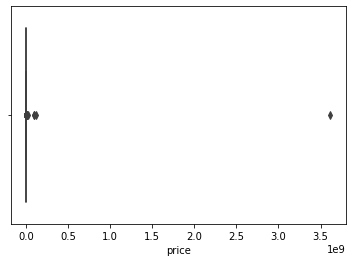

In [ ]:
# boxplot before removing outliers in price column
sns.boxplot(x = df_new['price'])

In [ ]:
# since price value can't be 0, remove the rows with price of 0
df_new = df_new[df_new['price']>0]

In [ ]:
# removing outliers from the price column using IQR
Q1 = df_new['price'].quantile(0.25)
Q3 = df_new['price'].quantile(0.75)

IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
print(lower_bound,upper_bound)

-18610.0 47950.0


In [ ]:
outliers = df_new[(df_new.price < lower_bound) | (df_new.price > upper_bound)]

In [ ]:
# new dataframe with price outliers dropPed
df_new = df_new.drop(outliers.index)

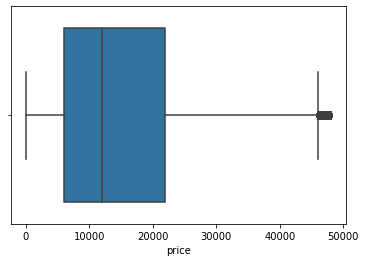

In [ ]:
# boxplot after removing outliers in price column
sns.boxplot(x = df_new['price'])

####Odometer column

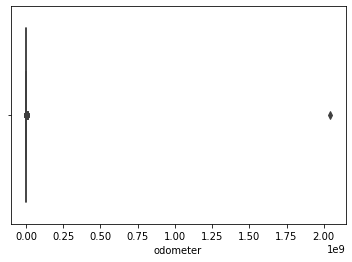

In [ ]:
# boxplot before removing outliers in odometer column
sns.boxplot(x = df_new['odometer'])

In [ ]:
# removing outliers from the odometer column using IQR
Q1 = df_new['odometer'].quantile(0.25)
Q3 = df_new['odometer'].quantile(0.75)

IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
print(lower_bound,upper_bound)

-86452.5 277471.5


In [ ]:
outliers = df_new[(df_new.odometer < lower_bound) | (df_new.odometer > upper_bound)]

In [ ]:
df_new = df_new.drop(outliers.index)

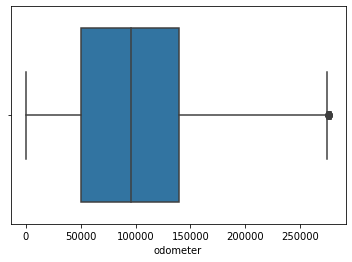

In [ ]:
# boxplot after removing outliers in odometer column
sns.boxplot(x = df_new['odometer'])

In [ ]:
gc.collect()

0

In [ ]:
# shape of the new dataset
df_new.shape

(171253, 15)

In [ ]:
#dropping the description column
df_new.drop('description', axis=1, inplace=True)

In [ ]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 171253 entries, 1 to 458211
Data columns (total 14 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   region        171253 non-null  object 
 1   year          171253 non-null  float64
 2   manufacturer  171253 non-null  object 
 3   model         171253 non-null  object 
 4   cylinders     171253 non-null  object 
 5   fuel          171253 non-null  object 
 6   odometer      171253 non-null  float64
 7   title_status  171253 non-null  object 
 8   transmission  171253 non-null  object 
 9   drive         171253 non-null  object 
 10  type          171253 non-null  object 
 11  paint_color   171253 non-null  object 
 12  state         171253 non-null  object 
 13  price         171253 non-null  int64  
dtypes: float64(2), int64(1), object(11)
memory usage: 19.6+ MB


**Using Label Encoder to convert categorical values to numbers** 

In [ ]:
le = LabelEncoder()

In [ ]:
df_new[['region','manufacturer','model','cylinders','fuel',
        'title_status','transmission','drive','type','paint_color',
        'state']] = df_new[['region','manufacturer','model',
        'cylinders','fuel','title_status','transmission','drive',
        'type','paint_color','state']].apply(le.fit_transform)

In [ ]:
df_new

,region,year,manufacturer,model,cylinders,fuel,odometer,title_status,transmission,drive,type,paint_color,state,price
1,16,2014.0,193,12207,3,2,93600.0,0,0,1,9,1,1,7500
3,16,1974.0,69,3412,3,2,190000.0,0,0,2,8,1,1,2000
4,16,2005.0,122,6947,6,0,116000.0,1,0,0,8,1,1,19500
5,16,2016.0,376,12741,5,2,33290.0,0,2,0,8,9,1,29590
6,16,2012.0,122,9618,6,2,9692.0,0,2,2,3,1,1,39990
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
458206,382,2013.0,69,3751,3,2,140000.0,0,0,1,0,1,48,5300
458208,382,2014.0,63,12466,5,2,83790.0,0,0,0,0,10,48,14995
458209,382,2018.0,193,13460,3,2,31888.0,0,0,0,0,11,48,17895
458210,397,2014.0,63,4814,5,2,53000.0,0,0,0,3,0,50,17900


In [ ]:
gc.collect()

12

In [ ]:
# converting the dataframe to a csv file
df_new.to_csv('new_vehicle.csv')

In [ ]:
# copying the new dataset into drive
!cp '/content/new_vehicle.csv' 'drive/My Drive/' 

###MODELLING THE DATA

####Using all the columns except price as the independent features

In [2]:
# copying dataset from drive to colab current directory
!cp 'drive/My Drive/new_vehicle.csv' '/content/'

In [8]:
# reading the dataset from the csv file
df_new = pd.read_csv('new_vehicle.csv')

In [9]:
# selecting features, X
X = df_new.iloc[:, :-1].values
# selecting labels, y
y = df_new.iloc[:, -1].values

In [10]:
# normalize the data
X = StandardScaler().fit_transform(X.astype(float))

In [11]:
# to split the data
# split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print('Train set: ', X_train.shape, y_train.shape)
print('Test set: ', X_test.shape, y_test.shape)

Train set:  (137002, 14) (137002,)
Test set:  (34251, 14) (34251,)


####Linear Regression

In [ ]:
# to create the linear reg model
reg = LinearRegression()
reg.fit(X_train, y_train)  # fit the model to train set

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
# to evaluate test set values
y_pred = reg.predict(X_test)

In [ ]:
print('Mean Absolute Error: ', round(metrics.mean_absolute_error(y_test, y_pred), 3))
print('Mean Squared Error: ', round(metrics.mean_squared_error(y_test, y_pred), 3))
print('Root Mean Squared Error: ', round(np.sqrt(metrics.mean_squared_error(y_test, y_pred)), 3))
print('R2 score: ', round(r2_score(y_test, y_pred), 3))

Mean Absolute Error:  5087.811
Mean Squared Error:  47231407.626
Root Mean Squared Error:  6872.511
R2 score:  0.604


In [ ]:
gc.collect()

113

####Decision Trees

In [ ]:
# create and fit the model to the train data
r = DecisionTreeRegressor(random_state=42, max_depth=15)
r.fit(X_train, y_train.ravel())

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=15,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=42, splitter='best')

In [ ]:
gc.collect()

0

In [ ]:
# to evaluate test set values
y_predDT = r.predict(X_test)

In [ ]:
print('Mean Absolute Error: ', round(metrics.mean_absolute_error(y_test, y_predDT), 3))
print('Mean Squared Error: ', round(metrics.mean_squared_error(y_test, y_predDT), 3))
print('Root Mean Squared Error: ', round(np.sqrt(metrics.mean_squared_error(y_test, y_predDT)), 3))
print('R2 score: ', round(r2_score(y_test, y_predDT), 3))

Mean Absolute Error:  2325.853
Mean Squared Error:  15703820.03
Root Mean Squared Error:  3962.805
R2 score:  0.868


####Random Forest

In [ ]:
r = RandomForestRegressor(n_estimators=150, random_state=42)
r.fit(X_train, y_train.ravel())

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=150, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [ ]:
gc.collect()

24

In [ ]:
y_predRF = r.predict(X_test)

In [ ]:
print('Mean Absolute Error: ', round(metrics.mean_absolute_error(y_test, y_predRF), 3))
print('Mean Squared Error: ', round(metrics.mean_squared_error(y_test, y_predRF), 3))
print('Root Mean Squared Error: ', round(np.sqrt(metrics.mean_squared_error(y_test, y_predRF)), 3))
print('R2 score: ', round(r2_score(y_test, y_predRF), 3))

Mean Absolute Error:  1606.267
Mean Squared Error:  8924741.064
Root Mean Squared Error:  2987.431
R2 score:  0.925


In [ ]:
gc.collect()

24

####Extra Trees

In [ ]:
r = ExtraTreesRegressor(n_estimators=400, random_state=42)
r.fit(X_train, y_train.ravel())

ExtraTreesRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mse',
                    max_depth=None, max_features='auto', max_leaf_nodes=None,
                    max_samples=None, min_impurity_decrease=0.0,
                    min_impurity_split=None, min_samples_leaf=1,
                    min_samples_split=2, min_weight_fraction_leaf=0.0,
                    n_estimators=400, n_jobs=None, oob_score=False,
                    random_state=42, verbose=0, warm_start=False)

In [ ]:
import gc
gc.collect()

271

In [ ]:
y_predET = r.predict(X_test)

In [ ]:
print('Mean Absolute Error: ', round(metrics.mean_absolute_error(y_test, y_predET), 3))
print('Mean Squared Error: ', round(metrics.mean_squared_error(y_test, y_predET), 3))
print('Root Mean Squared Error: ', round(np.sqrt(metrics.mean_squared_error(y_test, y_predET)), 3))
print('R2 score: ', round(r2_score(y_test, y_predET), 3))

Mean Absolute Error:  1489.648
Mean Squared Error:  8553142.44
Root Mean Squared Error:  2924.576
R2 score:  0.928


In [ ]:
gc.collect()

24

####CATBOOST REGRESSOR

In [ ]:
# to find the best parameters for catboost
from sklearn.model_selection import GridSearchCV
model = CatBoostRegressor()
parameters = {'depth'         : [6,8,10,12,14,16,18,20],
              'learning_rate' : [0.01, 0.05, 0.1, 0.5, 1],
              'iterations'    : [30, 50, 100]
              }
grid = GridSearchCV(model, parameters, cv = 2, n_jobs=-1)
gs = grid.fit(X_train, y_train)    

# Results from Grid Search
print("\n========================================================")
print(" Results from Grid Search " )
print("========================================================")    
    
print("\n The best estimator across ALL searched params:\n",
          gs.best_estimator_)
    
print("\n The best score across ALL searched params:\n",
          gs.best_score_)
    
print("\n The best parameters across ALL searched params:\n",
          gs.best_params_)

/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


0:	learn: 7137.0227037	total: 221ms	remaining: 21.9s
1:	learn: 5491.4440321	total: 366ms	remaining: 17.9s
2:	learn: 4818.6563977	total: 525ms	remaining: 17s
3:	learn: 4509.2378320	total: 668ms	remaining: 16s
4:	learn: 4330.8570965	total: 820ms	remaining: 15.6s
5:	learn: 4205.2697825	total: 969ms	remaining: 15.2s
6:	learn: 4150.1644435	total: 1.11s	remaining: 14.8s
7:	learn: 4068.1948468	total: 1.25s	remaining: 14.4s
8:	learn: 3994.6785058	total: 1.4s	remaining: 14.2s
9:	learn: 3917.5117319	total: 1.56s	remaining: 14s
10:	learn: 3861.2546221	total: 1.72s	remaining: 13.9s
11:	learn: 3828.1870998	total: 1.86s	remaining: 13.6s
12:	learn: 3791.8203106	total: 2.01s	remaining: 13.4s
13:	learn: 3726.3471503	total: 2.15s	remaining: 13.2s
14:	learn: 3699.1766785	total: 2.31s	remaining: 13.1s
15:	learn: 3684.7155811	total: 2.45s	remaining: 12.9s
16:	learn: 3653.8087178	total: 2.62s	remaining: 12.8s
17:	learn: 3623.2814283	total: 2.77s	remaining: 12.6s
18:	learn: 3592.7529407	total: 2.92s	remainin

In [ ]:
gc.collect()

0

In [ ]:
# using the best parameters gotten above
r = CatBoostRegressor(depth=12, iterations=100, learning_rate=0.5, random_state=42)
r.fit(X_train, y_train.ravel())

0:	learn: 7116.0630924	total: 157ms	remaining: 15.5s
1:	learn: 5484.8051225	total: 302ms	remaining: 14.8s
2:	learn: 4848.4628089	total: 450ms	remaining: 14.5s
3:	learn: 4485.5452692	total: 604ms	remaining: 14.5s
4:	learn: 4325.6251448	total: 749ms	remaining: 14.2s
5:	learn: 4215.1583422	total: 900ms	remaining: 14.1s
6:	learn: 4120.1483914	total: 1.06s	remaining: 14.1s
7:	learn: 4056.6734518	total: 1.22s	remaining: 14s
8:	learn: 3992.3752819	total: 1.36s	remaining: 13.8s
9:	learn: 3935.6835431	total: 1.5s	remaining: 13.5s
10:	learn: 3889.9379609	total: 1.65s	remaining: 13.4s
11:	learn: 3851.7626192	total: 1.8s	remaining: 13.2s
12:	learn: 3778.4258639	total: 1.95s	remaining: 13s
13:	learn: 3741.7275413	total: 2.09s	remaining: 12.9s
14:	learn: 3707.9742097	total: 2.25s	remaining: 12.7s
15:	learn: 3681.2914338	total: 2.39s	remaining: 12.6s
16:	learn: 3655.2099972	total: 2.55s	remaining: 12.5s
17:	learn: 3622.1127445	total: 2.69s	remaining: 12.3s
18:	learn: 3607.6400949	total: 2.84s	remaini

In [ ]:
gc.collect()

0

In [ ]:
y_predCAT = r.predict(X_test)

In [ ]:
print('Mean Absolute Error: ', round(metrics.mean_absolute_error(y_test, y_predCAT), 3))
print('Mean Squared Error: ', round(metrics.mean_squared_error(y_test, y_predCAT), 3))
print('Root Mean Squared Error: ', round(np.sqrt(metrics.mean_squared_error(y_test, y_predCAT)), 3))
print('R2 score: ', round(r2_score(y_test, y_predCAT), 3))

Mean Absolute Error:  2033.32
Mean Squared Error:  10580647.572
Root Mean Squared Error:  3252.791
R2 score:  0.911


In [ ]:
gc.collect()

110

####LGBM REGRESSOR

In [ ]:
r = LGBMRegressor(n_estimators=150, random_state=42)
r.fit(X_train, y_train.ravel())

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=150, n_jobs=-1, num_leaves=31, objective=None,
              random_state=42, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [ ]:
gc.collect()

60

In [ ]:
y_predLGBM = r.predict(X_test)

In [ ]:
print('Mean Absolute Error: ', round(metrics.mean_absolute_error(y_test, y_predLGBM), 3))
print('Mean Squared Error: ', round(metrics.mean_squared_error(y_test, y_predLGBM), 3))
print('Root Mean Squared Error: ', round(np.sqrt(metrics.mean_squared_error(y_test, y_predLGBM)), 3))
print('R2 score: ', round(r2_score(y_test, y_predLGBM), 3))

Mean Absolute Error:  2389.09
Mean Squared Error:  13343663.915
Root Mean Squared Error:  3652.898
R2 score:  0.888


In [ ]:
gc.collect()

89

####XGB REGRESSOR

In [ ]:
r = XGBRegressor(n_estimators=150, random_state=42)
r.fit(X_train, y_train.ravel())

[13:32:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=150,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [ ]:
gc.collect()

96

In [ ]:
y_predXGB = r.predict(X_test)

In [ ]:
print('Mean Absolute Error: ', round(metrics.mean_absolute_error(y_test, y_predXGB), 3))
print('Mean Squared Error: ', round(metrics.mean_squared_error(y_test, y_predXGB), 3))
print('Root Mean Squared Error: ', round(np.sqrt(metrics.mean_squared_error(y_test, y_predXGB)), 3))
print('R2 score: ', round(r2_score(y_test, y_predXGB), 3))

Mean Absolute Error:  3003.617
Mean Squared Error:  19457586.657
Root Mean Squared Error:  4411.075
R2 score:  0.837


####XGBRF REGRESSOR

In [ ]:
r = XGBRFRegressor(n_estimators=150, random_state=42)
r.fit(X_train, y_train.ravel())

[13:34:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRFRegressor(base_score=0.5, colsample_bylevel=1, colsample_bynode=0.8,
               colsample_bytree=1, gamma=0, learning_rate=1, max_delta_step=0,
               max_depth=3, min_child_weight=1, missing=None, n_estimators=150,
               n_jobs=1, nthread=None, objective='reg:linear', random_state=42,
               reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
               silent=None, subsample=0.8, verbosity=1)

In [ ]:
gc.collect()

98

In [ ]:
y_predXGBRF = r.predict(X_test)

In [ ]:
print('Mean Absolute Error: ', round(metrics.mean_absolute_error(y_test, y_predXGBRF), 3))
print('Mean Squared Error: ', round(metrics.mean_squared_error(y_test, y_predXGBRF), 3))
print('Root Mean Squared Error: ', round(np.sqrt(metrics.mean_squared_error(y_test, y_predXGBRF)), 3))
print('R2 score: ', round(r2_score(y_test, y_predXGBRF), 3))

Mean Absolute Error:  4767.293
Mean Squared Error:  41179565.691
Root Mean Squared Error:  6417.131
R2 score:  0.655


####**From all the models used, ExtraTrees Regressor gave the highest R2 score of 0.928 with the lowest mae value of 1489.648**